In [38]:
import os, keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.crane_dataset import CraneDataset
from sklearn.metrics import r2_score, mean_absolute_error


In [4]:
train_data_file_path_list = ['safe-boom-40-swing-180-load-40-.csv', 'safe-boom-50-swing-180-load-50-.csv',
                             'safe-boom-60-swing-180-load-60-.csv', 'safe-boom-70-swing-180-load-100-.csv',
                             'unsafe-swing-0-load-70-.csv', 'unsafe-swing-0-load-90-.csv',
                             'unsafe-swing-45-load-50-.csv', 'unsafe-swing-45-load-70-.csv',
                             'unsafe-swing-90-load-70-.csv', 'unsafe-swing-90-load-90-.csv',
                             'unsafe-swing-135-load-50-.csv', 'unsafe-swing-135-load-70-.csv']

for i, file_path in enumerate(train_data_file_path_list):
    train_data_file_path_list[i] = os.path.join('data', file_path)

In [5]:
val_data_file_path_list = ['safe-boom-80-swing-180-load-120-.csv', 'unsafe-swing-180-load-70-.csv', 'unsafe-swing-180-load-90-.csv']

for i, file_path in enumerate(val_data_file_path_list):
    val_data_file_path_list[i] = os.path.join('data', file_path)

In [6]:
train_data_file_path_list[0]

'data\\safe-boom-40-swing-180-load-40-.csv'

In [8]:
train_dataset_inst = CraneDataset([train_data_file_path_list[0]])
val_dataset_inst = CraneDataset([val_data_file_path_list[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
raw_train_dataset = train_dataset_inst.get_dataset()
raw_val_dataset = val_dataset_inst.get_dataset()

In [55]:
raw_train_data = raw_train_dataset[train_dataset_inst.get_data_target_names()]
raw_train_data = raw_train_data.to_numpy()
raw_train_data = raw_train_data.T.flatten()
raw_train_data = raw_train_data[::10]

In [56]:
raw_val_data = raw_val_dataset[val_dataset_inst.get_data_target_names()]
raw_val_data = raw_val_data.to_numpy()
raw_val_data = raw_val_data.T.flatten()
raw_val_data = raw_val_data[::10]

In [16]:
train_mean = 214865.13596315944
train_std = 94331.69969838172

In [57]:
scaled_raw_train_data = (raw_train_data-train_mean)/train_std
scaled_raw_val_data = (raw_val_data-train_mean)/train_std

In [58]:
def create_dataset(data, seq_len=1, pred_distance=1):
    feature, target = [], []
    
    for i in range(data.shape[0] - seq_len - pred_distance - 1):
        feature.append(data[i:(i + seq_len)])
        target.append(data[i + seq_len + pred_distance])
    
    return np.array(feature), np.array(target)

seq_len = 30
pred_distance = 30

scaled_x_train, scaled_y_train = create_dataset(data=scaled_raw_train_data, seq_len=seq_len, pred_distance=pred_distance)
scaled_x_val, scaled_y_val = create_dataset(data=scaled_raw_val_data, seq_len=seq_len, pred_distance=pred_distance)

# LSTM 입력에 맞게 데이터 형태를 조정합니다.
scaled_x_train = np.reshape(scaled_x_train, (scaled_x_train.shape[0], scaled_x_train.shape[1], 1))
scaled_x_val = np.reshape(scaled_x_val, (scaled_x_val.shape[0], scaled_x_val.shape[1], 1))

print(scaled_x_train.shape, scaled_y_train.shape, scaled_x_val.shape, scaled_y_val.shape)

(6740, 30, 1) (6740,) (5340, 30, 1) (5340,)


#### model load

In [25]:
best_model = keras.models.load_model('model.h5')

In [60]:
y_train_pred = best_model.predict(scaled_x_train)
y_val_pred = best_model.predict(scaled_x_val)

y_train_pred = (y_train_pred*train_std)+train_mean
y_val_pred = (y_val_pred*train_std)+train_mean

y_train = (scaled_y_train*train_std)+train_mean
y_val = (scaled_y_val*train_std)+train_mean

167/167 [==============================] - 2s 14ms/step


In [35]:
y_val_pred.squeeze()

array([278689.56 , 271842.   , 315649.22 , 378320.38 , 384952.6  ,
       387854.44 , 399247.53 , 411981.03 , 418125.5  , 412440.94 ,
       397021.5  , 382069.38 , 373631.88 , 373512.34 , 379522.97 ,
       386348.97 , 387911.4  , 381293.2  , 368861.12 , 356377.44 ,
       349361.   , 350129.12 , 357129.06 , 365259.88 , 368479.56 ,
       364097.94 , 354691.75 , 346173.12 , 343792.66 , 349532.5  ,
       361065.7  , 372351.1  , 376825.   , 372352.25 , 363469.12 ,
       357822.97 , 360759.44 , 372365.38 , 387491.16 , 398206.62 ,
       398101.34 , 387568.5  , 374685.56 , 369056.6  , 374825.38 ,
       388627.7  , 400621.6  , 397891.88 , 385310.7  , 383487.97 ,
       380093.   , 377468.03 , 383107.2  , 392330.62 , 393092.53 ,
       388164.12 , 402972.88 , 404647.8  , 394073.66 , 390307.66 ,
       395384.25 , 404616.25 , 411297.62 , 410108.7  , 400748.7  ,
       387872.28 , 377100.94 , 372375.6  , 374092.94 , 379327.2  ,
       383118.5  , 381246.94 , 373044.44 , 361897.16 , 352943.

<AxesSubplot:xlabel='Data Sample', ylabel='Loss'>

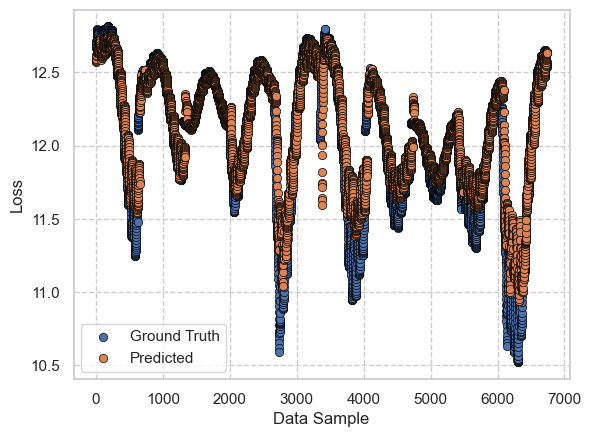

In [68]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Data Sample')
plt.ylabel('Loss')

x_axis_data = np.arange(0, len(y_train_pred), 1)
#for target_name, pred_target_name in zip(data_target_names, pred_target_names):
sns.scatterplot(x=x_axis_data, y=np.log(y_train), edgecolor='black', label='Ground Truth')
sns.scatterplot(x=x_axis_data, y=np.log(y_train_pred.squeeze()), edgecolor='black', label='Predicted')

In [39]:
r2_score(y_true=y_train, y_pred=y_train_pred)

0.89910277946514

<AxesSubplot:ylabel='Density'>

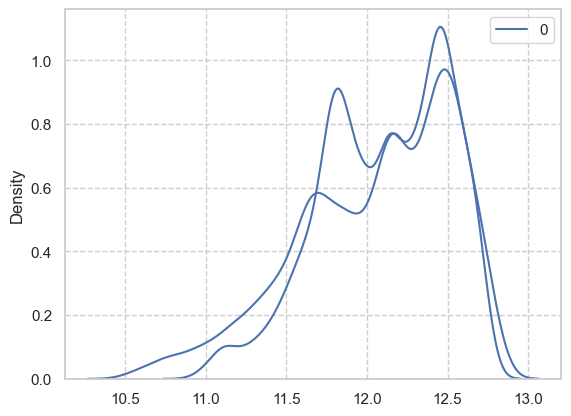

In [64]:
sns.kdeplot(np.log(y_train))
sns.kdeplot(np.log(y_train_pred))

In [65]:
y_train

array([316773.43, 318581.53, 320873.26, ..., 283854.66, 285558.39,
       287518.1 ])

In [62]:
np.log(y_train)

array([12.66594207, 12.6716337 , 12.6788015 , ..., 12.55621763,
       12.56220181, 12.56904109])

In [67]:
np.log(3167)

8.06054004653864